# Child Action Recognition based on our dataset
**Authors: Andrey Yershov, Aigerim Keutayeva, Serzhan Safin**

This work is based on the following paper: [Large-Scale Weakly-Supervised Pre-Training for Video Action Recognition](https://openaccess.thecvf.com/content_CVPR_2019/html/Ghadiyaram_Large-Scale_Weakly-Supervised_Pre-Training_for_Video_Action_Recognition_CVPR_2019_paper.html)

In this notebook, we finetune the pretrained R(2+1)D model from Microsoft Computer Vision library on our dataset.


##Installation, import and initialization of all required packages

In [ ]:
 pip install nteract-scrapbook

     |████████████████████████████████| 266kB 5.8MB/s 
     |████████████████████████████████| 1.1MB 28.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 112kB 37.7MB/s 
     |████████████████████████████████| 727kB 39.3MB/s 
     |████████████████████████████████| 747kB 44.2MB/s 
  Created wheel for black: filename=black-20.8b1-cp36-none-any.whl size=124186 sha256=10b177d30debfac8a599a2d89b877e35a533f33fbf331f1a461de09a4fead985
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


In [ ]:
 pip install git+https://github.com/microsoft/computervision-recipes.git

  Cloning https://github.com/microsoft/computervision-recipes.git to /tmp/pip-req-build-q7kd3q5c
  Running command git clone -q https://github.com/microsoft/computervision-recipes.git /tmp/pip-req-build-q7kd3q5c
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 983kB 4.2MB/s 
     |████████████████████████████████| 215kB 30.3MB/s 
     |████████████████████████████████| 2.1MB 30.7MB/s 
     |████████████████████████████████| 112kB 48.9MB/s 
     |████████████████████████████████| 14.1MB 253kB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 727kB 49.5MB/s 
     |████████████████████████████████| 40kB 5.9MB/s 
     |████████████████████████████████| 2.6MB 59.1MB/s 
     |████████████████████████████████| 92kB 11.3MB/s 
     |████████████████████████████████| 143kB 6

In [ ]:
 pip install decord --upgrade

     |████████████████████████████████| 11.8MB 218kB/s 


In [ ]:
 pip install einops

In [ ]:
import sys

sys.path.append("../../")

import numpy as np
import os
from pathlib import Path
import time
import warnings

from sklearn.metrics import accuracy_score
import scrapbook as sb
import torch
import torchvision

from utils_cv.action_recognition.data import Urls
from utils_cv.action_recognition.dataset import VideoDataset
from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path, unzip_url

system_info()
warnings.filterwarnings('ignore')

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] 

PyTorch 1.7.0+cu101 

Torch-vision 0.8.1+cu101 

Available devices:
0: Tesla P100-PCIE-16GB


In [ ]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing and preparing our dataset

We import the dataset from our Google Drive.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Path to FULL dataset, about 1400 videos (1 zip was damaged, causes COLAB crash)
# DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut'

# Path to cut dataset (working, max accuracy 75%, about 500 videos)
# DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut'

# Path to cut dataset excluding 'run' action (max accuracy 88%)
DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut-exclude-run'

# Number of consecutive frames used as input to the DNN. 32 for high accuracy, 8 for inference speed. 
# 32 only works with COLAB notebook with 25GB RAM
MODEL_INPUT_SIZE = 32

# Number of training epochs
EPOCHS = 35

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 5

# Learning rate
LR = 0.001

In [ ]:
os.listdir(Path(DATA_PATH))

['box', 'clap', 'go', 'jog', 'walk', 'wave']

## Loading the dataset into VideoDataset object

To load the data, we create a VideoDataset object using the `VideoDataset` helper class.

In [ ]:
# unfortunately, num_samples parameter causes error with tensor dimensions, when the is changed to any other than 1.
# higher number of samlples could have increased the accuracy, but we could not fix the error.

data = VideoDataset(DATA_PATH, batch_size=BATCH_SIZE, num_samples=1, sample_length=MODEL_INPUT_SIZE, video_ext="webm")

The `VideoDataset` will automatically divide the data into a training/validation set.  

Print the training and testing sets' lengthto make sure the train/test split looks right.

In [ ]:
print(
    f"Training dataset: {len(data.train_ds)}\
    \nTesting dataset: {len(data.test_ds)}"
)

Training dataset: 362    
Testing dataset: 120


Check the imported dataset using `show_batch` helper

<Figure size 432x288 with 0 Axes>

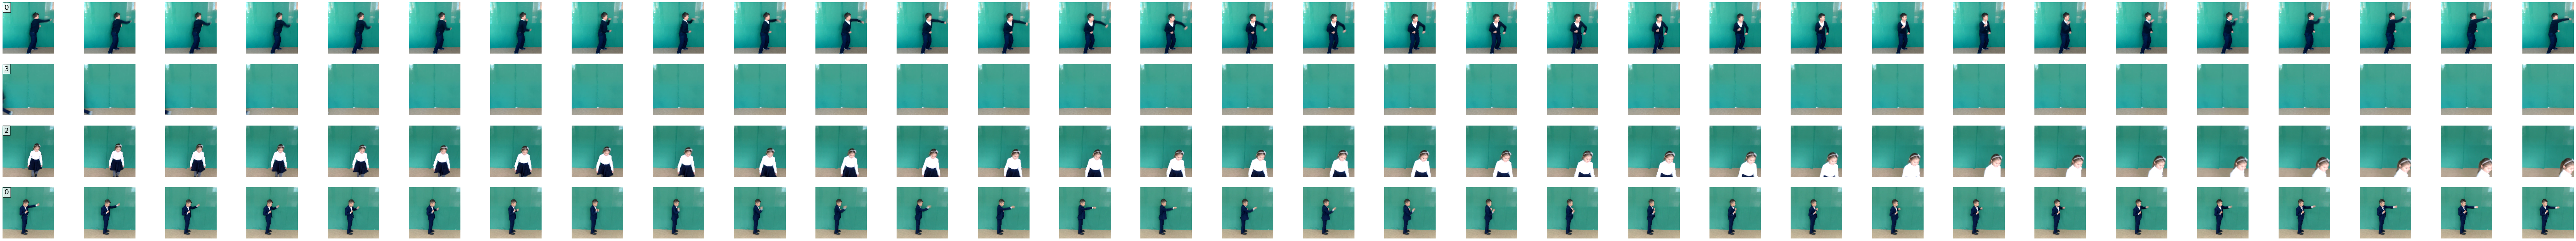

In [ ]:
data.show_batch(rows=4, train_or_test='test')

## Finetune a Pretrained Model

By default, the VideoLearner's R(2+1)D model is pretrained on __ig65m__ which is based on 65 million instagram videos. The dataset is described in this paper: https://arxiv.org/pdf/1905.00561.pdf

When we initialize the VideoLearner, we simply pass in the dataset. By default, the object will set the model to torchvision's ig65m R(2+1)D pre-trained model. Alternatively, we can also select the R(2+1)D model pretrained on the __kinetics__ dataset. However, it has proven to show lower accuracy overall.

In [ ]:
learner = VideoLearner(data, num_classes=6, base_model='ig65m')

Loading r2plus1d_34_32_ig65m model


Downloading: "https://github.com/moabitcoin/ig65m-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/moabitcoin/ig65m-pytorch/releases/download/v1.0.0/r2plus1d_34_clip32_ig65m_from_scratch-449a7af9.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_34_clip32_ig65m_from_scratch-449a7af9.pth


Check the model's Fully Connected layer.

In [ ]:
learner.model.fc

Linear(in_features=512, out_features=6, bias=True)

In the next block, our fine-tuned model could be pre-loaded, so that evaluation could be done without training. By default, the block is commented-out.

In [ ]:
# learner.load(model_name='88-trained-no-run-lr=OCP-epochs=35-bsize=5',model_dir='/content/gdrive/MyDrive/Final-project/trained-models/')

There is a function call on line 37 in the following file that causes fitting function crush. The view() function has to be replaced by reshape() function for the fit() method to work. This issue arises every time the code is downloaded from github. 

In [ ]:
#% /usr/local/lib/python3.6/dist-packages/utils_cv/action_recognition/references/metrics.py

Fine-tune the model using the `learner`'s `fit` function. One cycle policy has shown to increase the final accuracy, so it is used. The model is saved after training so that it could be reused for evaluation later.

Params to learn:
	full network
Epoch 1 =========================================================
lr=[3.9999999999999996e-05]
 Phase train: batch 10 of 73
 Phase train: batch 20 of 73
 Phase train: batch 30 of 73
 Phase train: batch 40 of 73
 Phase train: batch 50 of 73
 Phase train: batch 60 of 73
 Phase train: batch 70 of 73
train took 268.97 sec | loss = 1.7353 | top1_acc = 33.7017  | top5_acc = 88.9503
 Phase valid: batch 10 of 24
 Phase valid: batch 20 of 24
valid took 94.05 sec | loss = 1.5459 | top1_acc = 47.5000  | top5_acc = 98.3333
Epoch 2 =========================================================
lr=[6.600772398369546e-05]
 Phase train: batch 10 of 73
 Phase train: batch 20 of 73
 Phase train: batch 30 of 73
 Phase train: batch 40 of 73
 Phase train: batch 50 of 73
 Phase train: batch 60 of 73
 Phase train: batch 70 of 73
train took 263.40 sec | loss = 1.4737 | top1_acc = 50.0000  | top5_acc = 98.0663
 Phase valid: batch 10 of 24
 Phase valid: batch 20 of 24
valid took 95.20 s

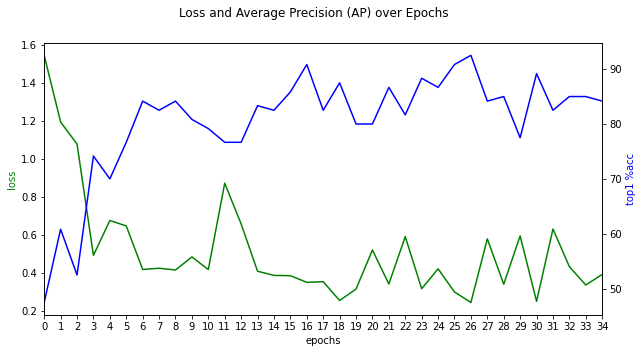

In [ ]:
model_path_name_pt = f'/content/gdrive/MyDrive/Final-project/trained-models3/trained-no-run-lr={LR}-epochs={EPOCHS}-bsize={BATCH_SIZE}.pt'

learner.fit(lr=LR, epochs=EPOCHS, model_dir='/content/gdrive/MyDrive/Final-project/training-models/', use_one_cycle_policy=True)

learner.save(model_path_name_pt)

## Evaluate

The dataset is composed of multiple videos with varying video lengths. But the model only takes in clips of a set length. This is why we need to take into consideration two types of accuracies when evaluating our model: clip-level accuracy and video-level accuracy. 

Our classifications are set at the video level, which mean that each video is assigned 1 classification. However, each video could have hundreds or thousands of frames. To make sure we're getting a good range of clips across those frames, we can sample a single video multiple times. The evaluation tool will sample 10 clips uniformly from each test video and pass it into the model in batches of [10 x 3 x 32 x 112 x 112]. The direct results of the model will show how many of those clips are correctly classified. 

In [ ]:
ret = learner.evaluate()

120 samples of torch.Size([3, 32, 112, 112])
Processsing 100 of 120 samples..
Avg. inference time per video (120 clips) = 613.73 ms
Video prediction accuracy = 0.88
Clip prediction accuracy = 0.83


## Predict using 3rd party video

Now that we've trained a model, we run a prediction on two of videos that we recorded with Andrey's younger brother and see how it works. He hasn't seen the videos from the dataset, we just asked him to perform the actions we name.

Total frames = 1816


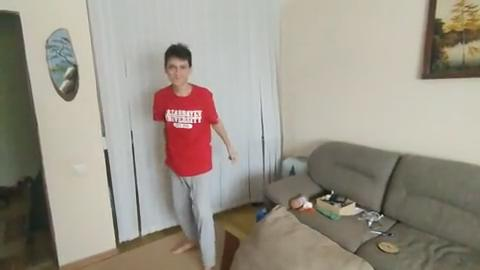

In [ ]:
# the first video checks waving, clapping and boxing
test_vid = str("/content/gdrive/MyDrive/HRI_project/predict-vids/1-480.mp4")
learner.predict_video(test_vid)

Total frames = 515


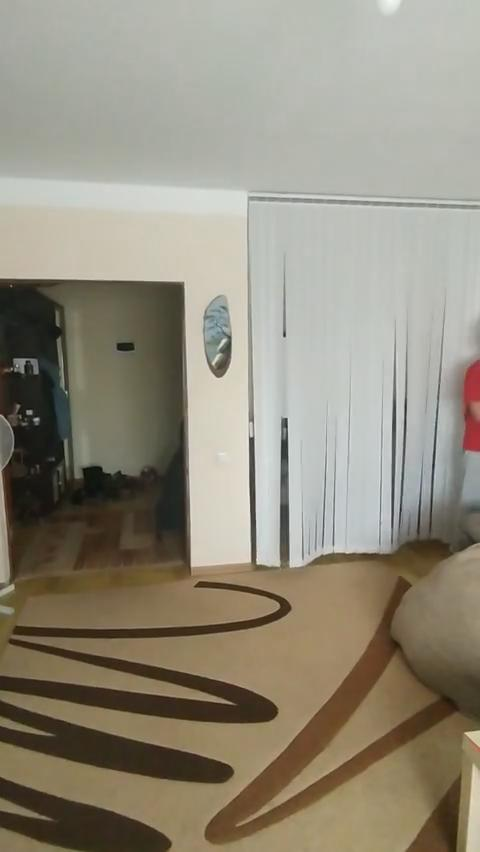

In [ ]:
# the second video checks walking and jogging
test_vid = str("/content/gdrive/MyDrive/HRI_project/predict-vids/2-480.mp4")
learner.predict_video(test_vid)

## Training model with all actions included (noisy, 75% accuracy)

In [ ]:
learner = VideoLearner(data, num_classes=7)

Loading r2plus1d_34_32_ig65m model


Using cache found in /root/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


Params to learn:
	full network
Epoch 1 =========================================================
lr=[3.9999999999999996e-05]
 Phase train: batch 10 of 115
 Phase train: batch 20 of 115
 Phase train: batch 30 of 115
 Phase train: batch 40 of 115
 Phase train: batch 50 of 115
 Phase train: batch 60 of 115
 Phase train: batch 70 of 115
 Phase train: batch 80 of 115
 Phase train: batch 90 of 115
 Phase train: batch 100 of 115
 Phase train: batch 110 of 115
train took 359.25 sec | loss = 1.8762 | top1_acc = 23.6324  | top5_acc = 84.6827
 Phase valid: batch 10 of 38
 Phase valid: batch 20 of 38
 Phase valid: batch 30 of 38
valid took 119.01 sec | loss = 1.7006 | top1_acc = 34.2105  | top5_acc = 97.3684
Epoch 2 =========================================================
lr=[9.498110768645931e-05]
 Phase train: batch 10 of 115
 Phase train: batch 20 of 115
 Phase train: batch 30 of 115
 Phase train: batch 40 of 115
 Phase train: batch 50 of 115
 Phase train: batch 60 of 115
 Phase train: batch 7

NameError: ignored

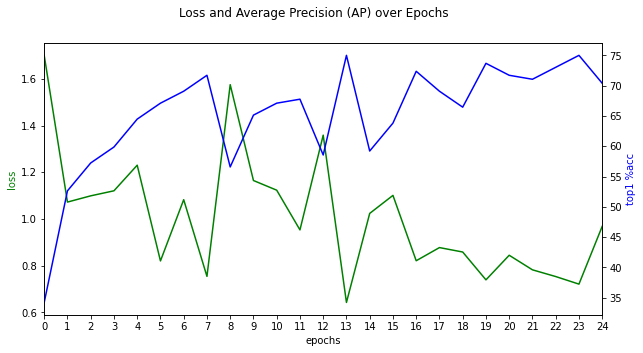

In [ ]:
model_path_name_pt = f'/content/gdrive/MyDrive/HRI_project/trained-models3/trained-lr={LR}-epochs={EPOCHS}-bsize={BATCH_SIZE}.pt'

learner.fit(lr=LR, epochs=EPOCHS, model_dir='/content/gdrive/MyDrive/HRI_project/training-models3/', use_one_cycle_policy=True)

learner.save(model_path_name_pt)

In [ ]:
ret = learner.evaluate()

152 samples of torch.Size([3, 32, 112, 112])
Processsing 100 of 152 samples..
Avg. inference time per video (152 clips) = 615.92 ms
Video prediction accuracy = 0.72
Clip prediction accuracy = 0.71


## Conclusion
With the **initial accuracy of 60%** on default setting, we believe that we have tuned the model as good as it could be tuned. While it shows a **75% accuracy** on our dataset with all actions included, we believe that the model that excludes the `run` action more accurately represents the abilities of the method with **88% accuracy**. 